In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('pharmacy_tx.csv') 

In [3]:
df[['type', 'drug']]=df['drug'].str.split(' ', expand = True)
df['tx_date'] = pd.to_datetime(df['tx_date'])

In [4]:
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,type
0,2022-01-02,Pharmacy #6,G99.93,tanoclolol,725700,1UQC,NaN,False,13.39,branded
1,2022-01-02,Pharmacy #42,U60.52,oxasoted,664344,NaN,52H8KH0F83K,False,7.02,branded
2,2022-01-02,Pharmacy #37,Q85.91,cupitelol,725700,1UQC,NaN,False,13.39,branded
3,2022-01-02,Pharmacy #30,U60.52,oxasoted,571569,KB38N,6BYJBW,False,10.84,generic
4,2022-01-02,Pharmacy #18,N55.01,mamate,664344,NaN,ZX2QUWR,False,47.00,branded
...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,Pharmacy #42,U27.71,colifunene,322463,NaN,HO8HUGL,True,0.00,branded
13910240,2022-12-30,Pharmacy #45,N59.44,tafistitrisin,664344,NaN,TFZOR5R49,False,6.28,generic
13910241,2022-12-30,Pharmacy #54,W50.87,tanoclolol,691847,N098KI,6SP1DG,False,6.94,generic
13910242,2022-12-30,Pharmacy #0,I68.27,prazinib,96934,S76J7V6,NaN,False,13.93,branded


In [5]:
col = ['pharmacy', 'diagnosis', 'drug', 'bin', 'pcn', 'group', 'type']

In [6]:
enc = OrdinalEncoder()
for i in col:
    df[i] = enc.fit_transform(df[[i]])

In [7]:
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,type
0,2022-01-02,54.0,37.0,67.0,8.0,0.0,NaN,False,13.39,0.0
1,2022-01-02,37.0,102.0,48.0,5.0,NaN,4.0,False,7.02,0.0
2,2022-01-02,31.0,89.0,8.0,8.0,0.0,NaN,False,13.39,0.0
3,2022-01-02,24.0,102.0,48.0,4.0,21.0,5.0,False,10.84,1.0
4,2022-01-02,10.0,75.0,38.0,5.0,NaN,47.0,False,47.00,0.0
...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,37.0,100.0,7.0,2.0,NaN,20.0,True,0.00,0.0
13910240,2022-12-30,40.0,76.0,66.0,5.0,NaN,38.0,False,6.28,1.0
13910241,2022-12-30,50.0,115.0,67.0,6.0,25.0,6.0,False,6.94,1.0
13910242,2022-12-30,0.0,52.0,52.0,0.0,34.0,NaN,False,13.93,0.0


In [8]:
#X = pd.concat([(df['tx_date'].astype('int') - df['tx_date'].astype('int')[0])/86400000000000, df.drop(columns=['tx_date','rejected','patient_pay'])], axis=1)
X = pd.concat([df['tx_date'].astype('int').astype('float'), df.drop(columns=['tx_date','rejected','patient_pay'])], axis=1)

In [9]:
y = df[['rejected', 'patient_pay']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
reg = lgbm.LGBMRegressor(n_estimators=500)
cl = lgbm.LGBMClassifier(n_estimators=500)

In [12]:
reg.fit(X_train, y_train.patient_pay, categorical_feature=col)
cl.fit(X_train, y_train.rejected, categorical_feature=col)

/opt/homebrew/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/homebrew/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(n_estimators=500)

In [13]:
pred1 = reg.predict(X_test)
pred2 = cl.predict(X_test)

In [14]:
finalpred = pred1* np.invert(pred2)

In [15]:
mse(y_test.patient_pay, finalpred)

#100 estimators
#627.5328071344909

#500 estimators
#624.5102918545587

#500 estimators with date converted to day of the year
#624.6484785279644

626.1897894500985

In [16]:
np.sqrt(mse(y_test.patient_pay, finalpred))

25.02378447497697

In [17]:
# One such fold
#cv_score= np.array([109.2249873 ,  82.3223107 ,  78.60574637,  78.88451118, 78.84462748])
# Mean, STD
#(85.79547105270053, 11.910502785502382)

In [18]:
featureimportance = pd.DataFrame({'LGBMRegressor':reg.feature_importances_, 
                                 'LGBMClassifier':cl.feature_importances_}, index=X.columns.values)

In [19]:
featureimportance

,LGBMRegressor,LGBMClassifier
tx_date,4238,976
pharmacy,2791,3677
diagnosis,1552,2295
drug,2706,3409
bin,378,259
pcn,1742,2015
group,1432,1947
type,161,422


<AxesSubplot:title={'center':'Feature Importance'}>

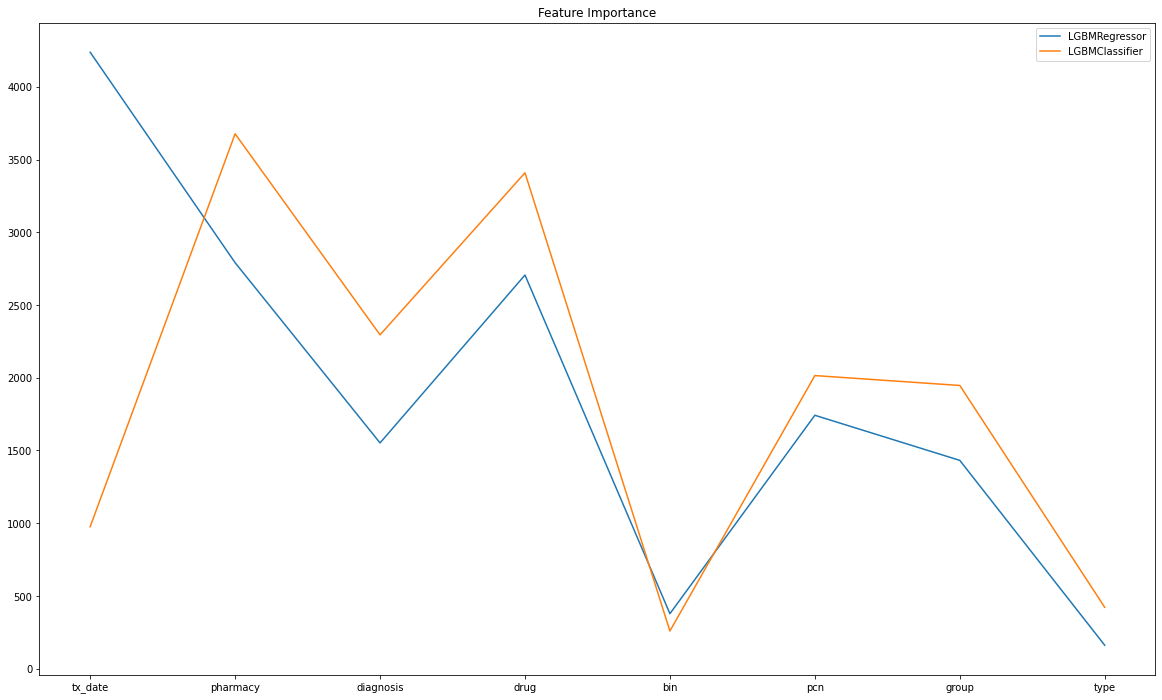

In [20]:
featureimportance.plot(figsize=(20,12), title='Feature Importance')

In [21]:
(pred2 == y_test.rejected).sum()/len(y_test)

0.9221458716219592

In [22]:
y_test.rejected.sum()

216577

In [23]:
(pred2 == True).sum()

61

In [24]:
len(y_test)

2782049